# Santa Tree Packing Optimization

The objective of this project is to arrange Christmas tree toys into the smallest packing arrangement possible—as defined by the size of a square bounding box around the trees—for toy counts of 1-200.

## 0. Notebook Dependencies

In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from shapely import affinity
from shapely.geometry import Polygon
from shapely.ops import unary_union
from shapely.strtree import STRtree
from decimal import Decimal, getcontext


## 1. Business Understanding

* Minimize the average square area per tree by optimally placing and rotating tree shapes inside the smallest possible square, across multiple configurations.

**Success Metric:**

$$ \text{Total Score} = \sum_{puzzles} \frac{s^2}{n} $$

Where:

$s$ = side length of minimal bounding square

$n$ = number of trees in that puzzle

**Hard Constraints:**

- No overlapping trees

- All trees must lie within coordinate bounds

- Output format must follow Kaggle spec

**Optimization Mindset:**

- Feasibility first, tightness second.

## 2. Data Understanding


### 2.1 Dataset Overview

- Each puzzle contains n ∈ [1, 200] trees

- Tree geometry is fixed (same shape across puzzles)

- Output requires (x, y, rotation) per tree

### 2.2 What We Do Not Learn From Data

- No labels

- No training signal

- No prediction task

- This is a pure optimization problem, not ML.

## 3. Modelling Assumptions

**Assumptions:**
- Trees are modeled as 2D convex polygons (triangles)
- Trees can be freely rotated
- Reference point is polygon centroid
- Bounding square is axis-aligned
- Objective depends only on max x/y extent

## 4. Geometry Layer (Core Abstraction)

### 4.1 Tree Shape Definition.

* First we need to design the base tree

In [2]:
# Set high precision for Decimal calculations

getcontext().prec = 25
scale_factor = Decimal('1')

# Create the ChristmasTree class
class ChristmasTree:
    """Represents a single, rotatable Christmas tree of a fixed size."""

    def __init__(self, center_x='0', center_y='0', angle='0'):
        """Initializes the Christmas tree with a specific position and rotation."""
        self.center_x = Decimal(center_x)
        self.center_y = Decimal(center_y)
        self.angle = Decimal(angle)

        trunk_w = Decimal('0.15')
        trunk_h = Decimal('0.2')
        base_w = Decimal('0.7')
        mid_w = Decimal('0.4')
        top_w = Decimal('0.25')
        tip_y = Decimal('0.8')
        tier_1_y = Decimal('0.5')
        tier_2_y = Decimal('0.25')
        base_y = Decimal('0.0')
        trunk_bottom_y = -trunk_h

        initial_polygon = Polygon(
            [
                # Start at Tip
                (Decimal('0.0') * scale_factor, tip_y * scale_factor),
                # Right side - Top Tier
                (top_w / Decimal('2') * scale_factor, tier_1_y * scale_factor),
                (top_w / Decimal('4') * scale_factor, tier_1_y * scale_factor),
                # Right side - Middle Tier
                (mid_w / Decimal('2') * scale_factor, tier_2_y * scale_factor),
                (mid_w / Decimal('4') * scale_factor, tier_2_y * scale_factor),
                # Right side - Bottom Tier
                (base_w / Decimal('2') * scale_factor, base_y * scale_factor),
                # Right Trunk
                (trunk_w / Decimal('2') * scale_factor, base_y * scale_factor),
                (trunk_w / Decimal('2') * scale_factor, trunk_bottom_y * scale_factor),
                # Left Trunk
                (-(trunk_w / Decimal('2')) * scale_factor, trunk_bottom_y * scale_factor),
                (-(trunk_w / Decimal('2')) * scale_factor, base_y * scale_factor),
                # Left side - Bottom Tier
                (-(base_w / Decimal('2')) * scale_factor, base_y * scale_factor),
                # Left side - Middle Tier
                (-(mid_w / Decimal('4')) * scale_factor, tier_2_y * scale_factor),
                (-(mid_w / Decimal('2')) * scale_factor, tier_2_y * scale_factor),
                # Left side - Top Tier
                (-(top_w / Decimal('4')) * scale_factor, tier_1_y * scale_factor),
                (-(top_w / Decimal('2')) * scale_factor, tier_1_y * scale_factor),
            ]
        )
        self.rotated = affinity.rotate(initial_polygon, float(self.angle), origin=(0, 0))
        self.polygon = affinity.translate(self.rotated,
                                          xoff=float(self.center_x * scale_factor),
                                          yoff=float(self.center_y * scale_factor))

### 4.2 Tree Creation

In [3]:
# Instantiate and display the Christmas tree
tree = ChristmasTree()
print(tree.polygon)

POLYGON ((0 0.8, 0.125 0.5, 0.0625 0.5, 0.2 0.25, 0.1 0.25, 0.35 0, 0.075 0, 0.075 -0.2, -0.075 -0.2, -0.075 0, -0.35 0, -0.1 0.25, -0.2 0.25, -0.0625 0.5, -0.125 0.5, 0 0.8))


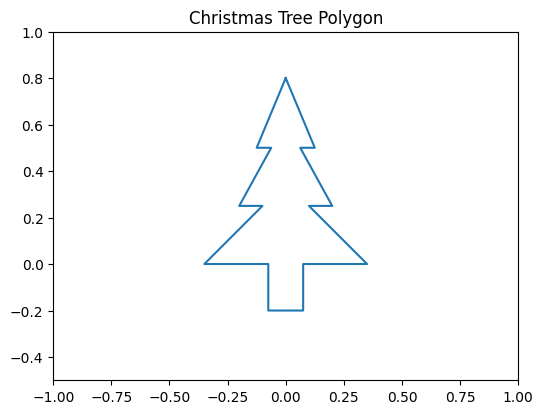

In [4]:
# Sanity check: Plot the tree polygon
plt.figure(figsize=(6, 6))
x, y = tree.polygon.exterior.xy
plt.plot(x, y)
plt.xlim(-1, 1)
plt.ylim(-0.5, 1)
plt.gca().set_aspect('equal', adjustable='box') 
plt.title('Christmas Tree Polygon')
plt.show()

### 4.3 Tree Operators

* This is to perform the tree transformations and rotations about the centroids

In [5]:
def transform_tree(base_polygon, x, y, deg):
    """
    Rotate (about centroid) then translate a tree polygon.
    """
    poly = affinity.rotate(
        base_polygon,
        deg,
        origin='centroid',
        use_radians=False
    )
    poly = affinity.translate(poly, xoff=x, yoff=y)
    return poly


def layout_to_polygons(layout, base_polygon):
    """
    Convert a list of (x, y, deg) into shapely polygons.
    """
    return [transform_tree(base_polygon, x, y, deg) for x, y, deg in layout]


def ensure_polygons(items, base_polygon):
    """
    Accept either polygons or (x, y, deg) tuples and return polygons.
    """
    if not items:
        return []
    first = items[0]
    if hasattr(first, 'geom_type'):
        return items
    return layout_to_polygons(items, base_polygon)


## 5. Feasibility Engine

### 5.1 Overlap Checking

* This is a sanity check to ensure the trees do not overlap in the square

In [6]:
def has_overlap(items, base_polygon=None):
    """
    Return True if any placed polygons overlap (touching is allowed).
    """
    if base_polygon is None:
        base_polygon = tree.polygon
    polygons = ensure_polygons(items, base_polygon)

    for i, poly in enumerate(polygons):
        for other in polygons[i + 1:]:
            if poly.intersects(other) and not poly.touches(other):
                return True
    return False


### 5.2 Bounding Square Computation

* This is the core decision logic for the square

In [24]:

def bounding_square_side(items, base_polygon=None):
    """
    Compute side length s of minimal axis-aligned square
    bounding all polygons.
    """
    if base_polygon is None:
        base_polygon = tree.polygon
    polygons = ensure_polygons(items, base_polygon)

    if not polygons:
        return 0.0

    xmin, ymin, xmax, ymax = polygons[0].bounds
    for polygon in polygons[1:]:
        x0, y0, x1, y1 = polygon.bounds
        xmin = min(xmin, x0)
        ymin = min(ymin, y0)
        xmax = max(xmax, x1)
        ymax = max(ymax, y1)

    width = xmax - xmin
    height = ymax - ymin
    return max(width, height)


## 6. Baseline Placement Strategy

### 6.1 Naive Feasible Placement

**Goal:**
- Never overlap
- Always inside bounds
- Terrible score is acceptable (for now)

**Example ideas:**

- Grid placement
- Spiral placement
- Line packing

In [25]:
# Place trees on a grid

def place_trees_baseline(n, base, spacing=None):
    """
    Baseline layout returning (x, y, deg) tuples on a grid.
    """
    if hasattr(base, 'polygon'):
        base_polygon = base.polygon
    else:
        base_polygon = base

    minx, miny, maxx, maxy = base_polygon.bounds
    width = maxx - minx
    height = maxy - miny
    step = spacing if spacing is not None else max(width, height) * 1.05

    layout = []
    side = math.ceil(math.sqrt(n))

    for i in range(side):
        for j in range(side):
            if len(layout) >= n:
                break
            layout.append((float(i * step), float(j * step), 0.0))

    return layout


def place_trees_grid(n, spacing=None):
    """
    Place trees on a square grid.
    Guaranteed no overlap if spacing is large enough.
    """
    layout = place_trees_baseline(n, tree, spacing=spacing)
    return layout_to_polygons(layout, tree.polygon)


* Now we call the function to fit the trees

In [51]:
polys = place_trees_grid(40)
has_overlap(polys)


False

## 7. Optimization layer

### 7.1 Objective Function

In [27]:
# Compute puzzle score

def puzzle_score(items, base_polygon=None):
    """
    s^2 / n
    """
    if base_polygon is None:
        base_polygon = tree.polygon
    polygons = ensure_polygons(items, base_polygon)
    n = len(polygons)
    if n == 0:
        return 0.0
    s = bounding_square_side(polygons)
    return (s ** 2) / n


* Now we calculate the puzzle score for the 25 placed trees

In [52]:
puzzle_score(polys)

1.3322500000000004

* Lets plot the polygons to see the fit.

In [29]:
def plot_layout(items, show_square=True, base_polygon=None):
    if base_polygon is None:
        base_polygon = tree.polygon
    polygons = ensure_polygons(items, base_polygon)

    fig, ax = plt.subplots(figsize=(6, 6))

    for poly in polygons:
        x, y = poly.exterior.xy
        ax.fill(x, y, alpha=0.6, edgecolor='black')

    if show_square and len(polygons) > 0:
        union = unary_union(polygons)
        xmin, ymin, xmax, ymax = union.bounds
        s = max(xmax - xmin, ymax - ymin)
        ax.plot(
            [xmin, xmin + s, xmin + s, xmin, xmin],
            [ymin, ymin, ymin + s, ymin + s, ymin],
            linestyle='--',
            color='red'
        )

    ax.set_aspect('equal')
    plt.show()


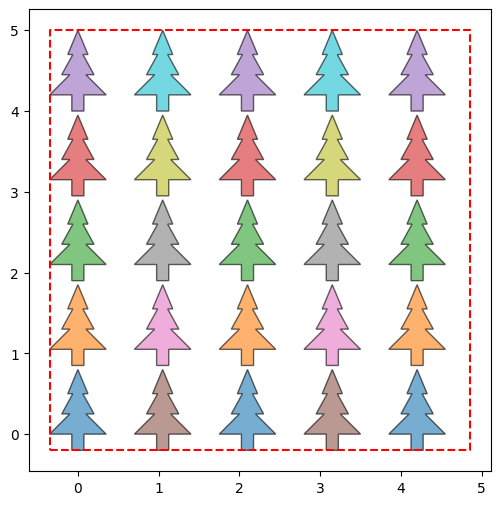

In [13]:
plot_layout(polys)

### 7.2 Local Improvement Hueristics

#### 7.2.1 🎯 Optimizer 1: Center-Pull Compaction (Monotonic & Safe)
**Idea (in human terms):**
* Compute the current center of the layout

- For each tree:

    - Try to move it slightly toward the center

- Accept the move only if:

    - No overlaps are introduced
    - The bounding square side s does not increase
    - Repeat until no more improvement
    - This works because grid layouts are wasteful at the edges.

* First we need to determine the distance of the centroids

In [30]:

def layout_center(polygons):
    """
    Compute centroid of all tree centroids.
    """
    xs, ys = [], []
    for p in polygons:
        c = p.centroid
        xs.append(c.x)
        ys.append(c.y)
    return np.mean(xs), np.mean(ys)


* Now we then try to move the trees together towards the center in increments using a minimization function of its derivative i.e  $\frac{dy}{dx}$

In [31]:
def try_move(polygons, idx, dx, dy):
    """
    Try moving polygon idx by (dx, dy).
    Return new polygons list if valid, else None.
    """
    new_polys = polygons.copy()
    moved = affinity.translate(new_polys[idx], xoff=dx, yoff=dy)
    new_polys[idx] = moved

    if has_overlap(new_polys):
        return None

    return new_polys


* Now we can create a function that will pull the objects towards the center from their point of their centroids.

In [32]:
def center_pull_optimizer(polygons, 
                          step=0.1, 
                          max_iters=100,
                          tol=1e-6,
                          verbose=False):
    """
    Greedy center-pull optimization.
    """
    polys = polygons
    best_s = bounding_square_side(polys)

    for it in range(max_iters):
        improved = False
        cx, cy = layout_center(polys)

        for i, poly in enumerate(polys):
            px, py = poly.centroid.x, poly.centroid.y

            # Direction toward center
            vx = cx - px
            vy = cy - py
            norm = math.hypot(vx, vy)

            if norm < tol:
                continue

            dx = step * vx / norm
            dy = step * vy / norm

            candidate = try_move(polys, i, dx, dy)
            if candidate is None:
                continue

            new_s = bounding_square_side(candidate)

            if new_s <= best_s + tol:
                polys = candidate
                best_s = new_s
                improved = True

        if verbose:
            print(f"Iter {it:03d} | s = {best_s:.4f}")

        if not improved:
            break

    return polys


* Now we plot the results and check the score

Iter 000 | s = 5.1293
Iter 001 | s = 5.1106
Iter 002 | s = 5.1106
Iter 003 | s = 5.0846
Iter 004 | s = 5.0553
Iter 005 | s = 5.0293
Iter 006 | s = 5.0000
Iter 007 | s = 5.0000
Iter 008 | s = 5.0000
Iter 009 | s = 5.0000
Iter 010 | s = 5.0000
Iter 011 | s = 5.0000
Iter 012 | s = 5.0000
Iter 013 | s = 5.0000
Iter 014 | s = 5.0000
Iter 015 | s = 5.0000


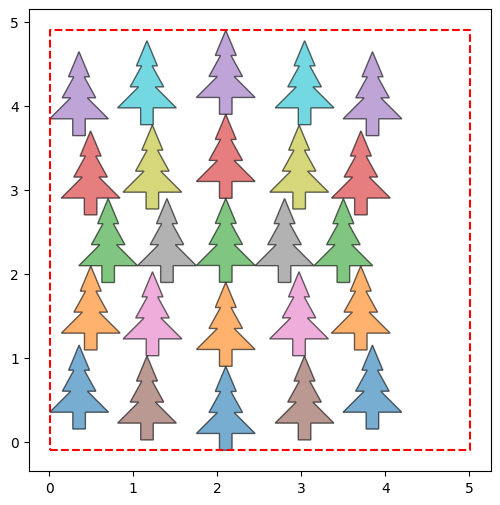

Center-pull score: 1.0000


In [33]:
center_pull = center_pull_optimizer(polys, step=0.05, max_iters=50, verbose=True)
plot_layout(center_pull)
center_score = puzzle_score(center_pull)
print(f"Center-pull score: {center_score:.4f}")

* Now we can try for a puzzle range of 1 to 200 toy trees then tally the score of them , we should also log results of the method below to compare methods to find the optimum startegy

In [34]:
# Creating a experiment log function to display avarage scores, present overlaps and methods used
def log_experiment(method_name, layout, base_polygon=None):
    """
    Log experiment details including method name, average score, and overlap status.
    """
    if base_polygon is None:
        base_polygon = tree.polygon
    polygons = ensure_polygons(layout, base_polygon)
    score = puzzle_score(polygons, base_polygon)
    overlap = has_overlap(polygons, base_polygon)
    
    print(f"Method: {method_name}")
    print(f"Average Score: {score:.4f}")
    print(f"Overlap Present: {'Yes' if overlap else 'No'}")
    print("-" * 30) 

Method: Center Pull Optimization with 40 Trees
Average Score: 1.2968
Overlap Present: No
------------------------------


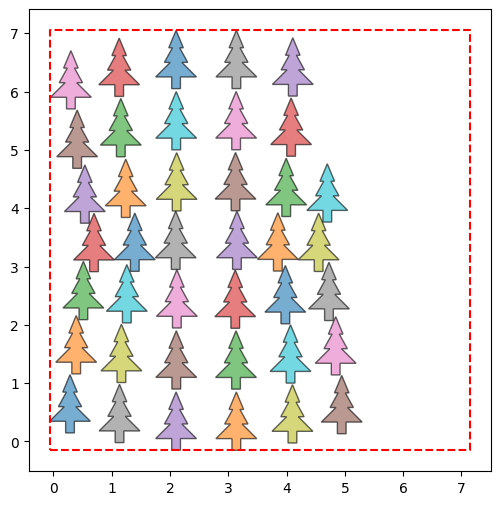

In [ ]:
# Testing layout of center pull with a range of 40 trees

layout = place_trees_grid(40)
optimized_layout = center_pull_optimizer(layout, step=0.05, max_iters=100, verbose=False)
log_experiment(f"Center Pull Optimization with {40} Trees", optimized_layout)
plot_layout(optimized_layout)

#### 7.2.2 Axis-wise Compaction (X then Y)

Instead of pulling trees diagonally toward the center (which can cause subtle conflicts), we:

1. Compress along X-axis only
2. Then compress along Y-axis only
3. Move trees independently

Accept a move only if:

- No overlaps
- Bounding square side s does not increase

This mirrors how humans pack things into boxes:

_push left, then push down._

* First we need to create a helper function that allow us to isolate the axis which we want to to move the trees.

In [37]:
# Helper function to try moving along one axis
def try_axis_move(polygons, idx, axis, step):
    """
    Try moving polygon idx along one axis.
    axis: 'x' or 'y'
    """
    dx, dy = (step, 0.0) if axis == 'x' else (0.0, step)
    return try_move(polygons, idx, dx, dy)


* This becomes the core engine for the axis compaction

In [38]:
def axis_compaction(polygons, axis='x', step=0.1, tol=1e-6):
    """
    One greedy compaction pass along a single axis.
    """
    polys = polygons
    best_s = bounding_square_side(polys)

    # Sort by centroid along chosen axis
    if axis == 'x':
        order = sorted(range(len(polys)), key=lambda i: polys[i].centroid.x)
        directions = [+1, -1]  # push right then left
    else:
        order = sorted(range(len(polys)), key=lambda i: polys[i].centroid.y)
        directions = [+1, -1]  # push up then down

    for direction in directions:
        for i in order:
            while True:
                candidate = try_axis_move(polys, i, axis, direction * step)
                if candidate is None:
                    break

                new_s = bounding_square_side(candidate)
                if new_s <= best_s + tol:
                    polys = candidate
                    best_s = new_s
                else:
                    break

    return polys


* Now we can build the full optimizer similar to the centered optimizer

In [39]:
def axis_compaction_optimizer(polygons,
                              step=0.1,
                              max_iters=20,
                              tol=1e-6,
                              verbose=False):
    """
    Alternating X/Y compaction until convergence.
    """
    polys = polygons
    best_s = bounding_square_side(polys)

    for it in range(max_iters):
        before = best_s

        polys = axis_compaction(polys, axis='x', step=step, tol=tol)
        polys = axis_compaction(polys, axis='y', step=step, tol=tol)

        best_s = bounding_square_side(polys)

        if verbose:
            print(f"Iter {it:02d} | s = {best_s:.4f}")

        if abs(before - best_s) < tol:
            break

    return polys


Iter 00 | s = 7.0000
Iter 01 | s = 7.0000
Method: Axis Compaction Optimization with 40 Trees
Average Score: 1.2250
Overlap Present: No
------------------------------


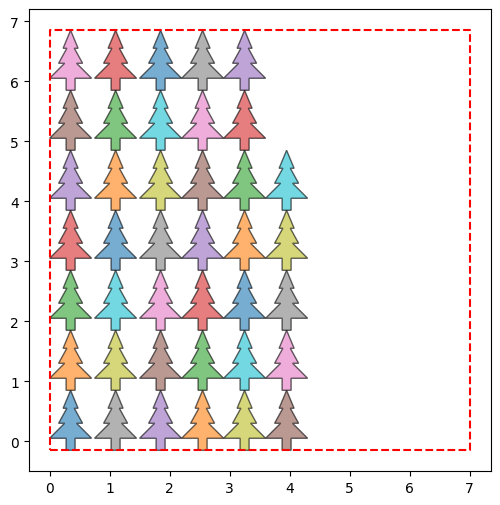

In [47]:
layout = place_trees_grid(40)
axis_optimized_layout = axis_compaction_optimizer(layout, step=0.05, max_iters=50, verbose=True)
log_experiment(f"Axis Compaction Optimization with {40} Trees", axis_optimized_layout)
plot_layout(axis_optimized_layout)

## 8. Solver Orchestration

In [ ]:
def solve_puzzle(puzzle_id, n):
    layout = place_trees_baseline(n, tree)
    layout = improve_layout(layout)
    return layout

## 9. Evaluation & Diagnostics

### 9.1 Tree Visualization (For Debugging)

In [ ]:
# plot_layout is defined above and supports polygons or (x, y, deg) layouts.


### 9.2 Stress Testing

- n = 1
- n = 200
- Random seeds
- Worst-case geometry

In [ ]:
# Test Layout and Scoring
    


## 10. Submission Generation

### 10.1 Formatting Utilities 

In [ ]:
# Format fuction to submit values as string sXXXXXX

def fmt(val):
    return f"s{val:.6f}"

### 10.2 Submission Builder

In [ ]:
# Creating a database with results

BOUNDS = (-100.0, 100.0)


def validate_layout(layout, base_polygon=None, bounds=BOUNDS):
    """
    Validate layout against competition constraints.
    """
    if base_polygon is None:
        base_polygon = tree.polygon

    if layout is None:
        raise ValueError("Layout is None.")

    min_b, max_b = bounds
    for idx, item in enumerate(layout):
        try:
            x, y, deg = item
        except Exception as exc:
            raise ValueError("Layout entries must be (x, y, deg).") from exc

        xf = float(x)
        yf = float(y)
        if not (min_b < xf < max_b) or not (min_b < yf < max_b):
            raise ValueError(
                f"Tree {idx} out of bounds: x={x}, y={y} (bounds {min_b}, {max_b})."
            )

    if has_overlap(layout, base_polygon=base_polygon):
        raise ValueError("Layout has overlapping trees; submission rejected.")


def build_submission(all_puzzles, base_polygon=None):
    if base_polygon is None:
        base_polygon = tree.polygon

    rows = []
    for puzzle_id, layout in all_puzzles.items():
        validate_layout(layout, base_polygon=base_polygon)
        for i, (x, y, deg) in enumerate(layout):
            rows.append({
                "id": f"{puzzle_id}_{i}",
                "x": fmt(x),
                "y": fmt(y),
                "deg": fmt(deg)
            })
    return pd.DataFrame(rows)


## 11. Experiment Log

In [53]:
log_experiment("Baseline Grid Layout with 40 Trees", polys)

Method: Baseline Grid Layout with 40 Trees
Average Score: 1.3323
Overlap Present: No
------------------------------


In [54]:
log_experiment("Center Pull Optimization with 40 Trees", optimized_layout)

Method: Center Pull Optimization with 40 Trees
Average Score: 1.2968
Overlap Present: No
------------------------------


In [50]:
log_experiment("Axis-Compaction Optimization with 40 Trees", axis_optimized_layout)

Method: Axis-Compaction Optimization with 40 Trees
Average Score: 1.2250
Overlap Present: No
------------------------------
